<a href="https://colab.research.google.com/github/rhanschristiansen/entropy/blob/master/entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
def clone_source_code():
  """
  Clone the github repo and move to this working directory
  """
  print("Downloading source code...")
  !_=$(git clone --quiet https://github.com/rhanschristiansen/entropy.git)
  !mv entropy/* .
  !rm -rf entropy/

def download_extract_data():
  """
  Download data.zip from Google Drive and extract to this working directory
  """
  print("Downloading data...")
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1ornFmw59u_It0Cpi8yDHRdpW4G_6YLj5" > /dev/null
  !curl -s -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1ornFmw59u_It0Cpi8yDHRdpW4G_6YLj5" -o "data.zip"
  print("Extracting data...")
  !unzip -q data.zip

def setup():
  import sys
  sys.path.append('./') #add the parent directory to the path
  !rm -rf *
  clone_source_code()
  download_extract_data()
  print("Setup Complete.")

setup()

Extracting data...
Setup Complete.


## Calculation of Entropy from Images and Lidar Data

In [3]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

Define the function to calculate the Entropy from a normalized histogram

In [4]:
def entropy(hist):
    entropy = 0
    for i in range(len(hist)):
        if hist[i] > 0:
            entropy -= np.log2(hist[i])*hist[i]
    return entropy

Test the resolution on the Lena image prior to edge detection and after edge detection

In [5]:
#  Simply open and save to convert some of the images to png.
im = Image.open('images/lenagrey.gif')
im.save('images/lenagrey.png')
im = Image.open('images/lenacanny.gif')
im.save('images/lenacanny.png')
im = Image.open('images/lenacannylowradius.gif')
im.save('images/lenacannylowradius.png')

img_names = ['lena grey scale', 'lena canny', 'lena canny low radius']
lenagrey = cv2.imread('images/lenagrey.png')
lenacanny = cv2.imread('images/lenacanny.png')
lenacannylowradius = cv2.imread('images/lenacannylowradius.png')

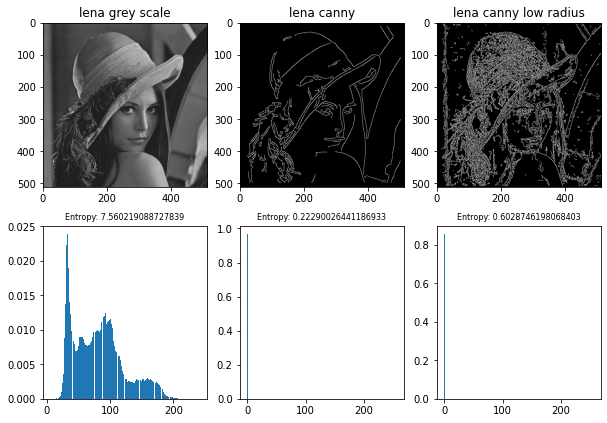

In [6]:
imgs = [lenagrey, lenacanny, lenacannylowradius]
hists = []
e2 = []
fig, axes = plt.subplots(2, 3, figsize=(10,7))
for i, (img, name) in enumerate(zip(imgs, img_names)):
    hist, _, _ = axes[1,i].hist(img.ravel(), bins=256, density=True)
    hist2, _ = np.histogram(img, bins=256, density=True)
    e2.append(entropy(hist2))
    ax2 = axes[0,i]
    ax2.imshow(img)
    ax2.set_title(name)
    e = entropy(hist)
    axes[1,i].set_title('Entropy: ' + str(e), fontsize=8)


plt.show()

In [7]:
print(e2)

[7.560219088727839, 0.22290026441186933, 0.6028746198068403]


### Evaluate the entropy of the Kitty data images

In [13]:
!ls data/2011_09_26/

0015_filtered.csv	    calib_cam_to_cam.txt   calib_velo_to_cam.txt
2011_09_26_drive_0015_sync  calib_imu_to_velo.txt


In [14]:
im_dir = 'data/2011_09_26/2011_09_26_drive_0015_sync/image_02/data/'

os.path.exists(im_dir)

True

In [15]:
images = sorted([f for f in glob.glob(im_dir+'*.png', recursive=False)])
len(images)

297

In [16]:
im = cv2.imread(images[0])

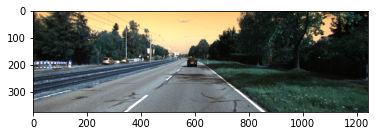

In [17]:
plt.imshow(im)

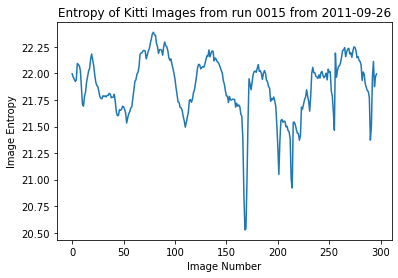

In [19]:
entropies = []
for i, f in enumerate(images):
    im = cv2.imread(images[i])
    e = 0
    for c in range(3):
        im_flat = im[:,:,c].ravel()
        hist, _ = np.histogram(im_flat, bins=256, density=True )
        e += entropy(hist)
    entropies.append(e)
plt.plot(entropies)
plt.title('Entropy of Kitti Images from run 0015 from 2011-09-26')
plt.xlabel('Image Number')
_ = plt.ylabel('Image Entropy')

### Evaluate the Entropy of the Lidar data (Full Resolution)

In [26]:
lidar_dir = 'data/2011_09_26/2011_09_26_drive_0015_sync/velodyne_points/data/'
lidar_f = sorted([f for f in glob.glob(lidar_dir+'*.bin', recursive=False)])


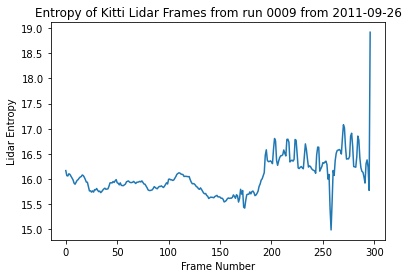

In [21]:
lidar_entropies = []
for i, f in enumerate(lidar_f):    
    vals = np.fromfile(f, dtype = np.float32)
    vals = vals.reshape(len(vals)//4, 4)
    dists = np.sqrt(vals[:,0]**2 + vals[:,1]**2 + vals[:,2]**2)
    hist, _ = np.histogram(dists, bins=256, density=True)
    e = entropy(hist)
    lidar_entropies.append(e)

plt.plot(lidar_entropies)
plt.title('Entropy of Kitti Lidar Frames from run 0009 from 2011-09-26')
plt.xlabel('Frame Number')
_ = plt.ylabel('Lidar Entropy')

### Evaluate the Entropy of the Lidar Data (at different resolutions)

In [22]:
f = lidar_f[0]
vals = np.fromfile(f, dtype = np.float32)
vals = vals.reshape(len(vals)//4, 4)
dists = np.sqrt(vals[:,0]**2 + vals[:,1]**2 + vals[:,2]**2)

In [23]:
downsample_factors = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16284]

In [24]:
entropies = []
for factor in downsample_factors:
    d = dists[::factor]
    print(d.shape)
    hist, _ = np.histogram(d, bins=256, density=True)
    e = entropy(hist)
    entropies.append(e)

(123839,)
(61920,)
(30960,)
(15480,)
(7740,)
(3870,)
(1935,)
(968,)
(484,)
(242,)
(121,)
(61,)
(31,)
(16,)
(8,)


In [25]:
entropies

[16.16790970798721,
 16.176255236794265,
 16.208376678685468,
 16.198352113579418,
 16.2060686498658,
 16.55076009468253,
 17.807047670577735,
 17.539632969116354,
 18.589591182560625,
 17.81706791567353,
 16.236757312391507,
 14.22134814724112,
 11.700882890961054,
 8.0536646127554,
 2.946275153955628]